First you need to download and extract the dataset and code.

In [1]:
import os
import xml.etree.ElementTree as ET
from PIL import Image

class RoadDamageDataset:
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.image_dir = os.path.join(root_dir, 'JPEGImages')
        self.annotation_dir = os.path.join(root_dir, 'Annotations')
        self.image_sets_dir = os.path.join(root_dir, 'ImageSets', 'Main')
        self.images = []
        self.annotations = []

        # Загрузка списка изображений
        with open(os.path.join(self.image_sets_dir, 'train.txt'), 'r') as f:
            self.images = f.read().splitlines()

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx] + '.jpg'
        annotation_name = self.images[idx] + '.xml'

        # Загрузка изображения
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert("RGB")

        # Загрузка и парсинг аннотации
        annotation_path = os.path.join(self.annotation_dir, annotation_name)
        tree = ET.parse(annotation_path)
        root = tree.getroot()

        boxes = []
        labels = []

        for obj in root.findall('object'):
            label = obj.find('name').text
            labels.append(label)
            bbox = obj.find('bndbox')
            xmin = int(bbox.find('xmin').text)
            ymin = int(bbox.find('ymin').text)
            xmax = int(bbox.find('xmax').text)
            ymax = int(bbox.find('ymax').text)
            boxes.append([xmin, ymin, xmax, ymax])

        return image, boxes, labels


# Пример использования
dataset = RoadDamageDataset(root_dir='/Users/olya/Desktop/Diploma/RoadDamageDataset/Adachi')
image, boxes, labels = dataset[0]
image.show()
print(boxes, labels)

[[170, 284, 361, 462], [375, 186, 595, 476]] ['D10', 'D01']


In [5]:
import os
import random
import shutil

# Пути к исходным изображениям и аннотациям
dataset_path = "/Users/olya/Desktop/Diploma/RoadDamageDataset/Adachi"  # Замени на реальный путь
image_dir = os.path.join(dataset_path, "JPEGImages")
annotation_dir = os.path.join(dataset_path, "Annotations")

# Пути для раздельных выборок
output_dir = os.path.join(dataset_path, "SplitDataset")
train_img_dir = os.path.join(output_dir, "train", "images")
train_ann_dir = os.path.join(output_dir, "train", "annotations")
test_img_dir = os.path.join(output_dir, "test", "images")
test_ann_dir = os.path.join(output_dir, "test", "annotations")

# Создаём директории, если их нет
os.makedirs(train_img_dir, exist_ok=True)
os.makedirs(train_ann_dir, exist_ok=True)
os.makedirs(test_img_dir, exist_ok=True)
os.makedirs(test_ann_dir, exist_ok=True)

# Получаем список всех файлов изображений (аннотации имеют те же имена)
image_files = sorted([f for f in os.listdir(image_dir) if f.endswith(".jpg")])
random.shuffle(image_files)  # Перемешиваем данные для случайного разбиения

# Определяем количество данных для train/test
train_size = int(0.8 * len(image_files))  # 80% данных идёт на обучение
train_files = image_files[:train_size]
test_files = image_files[train_size:]

# Функция копирования файлов в соответствующие папки
def copy_files(file_list, src_img_dir, src_ann_dir, dst_img_dir, dst_ann_dir):
    for file in file_list:
        img_src = os.path.join(src_img_dir, file)
        ann_src = os.path.join(src_ann_dir, file.replace(".jpg", ".xml"))
        
        img_dst = os.path.join(dst_img_dir, file)
        ann_dst = os.path.join(dst_ann_dir, file.replace(".jpg", ".xml"))

        if os.path.exists(ann_src):  # Проверяем, есть ли аннотация для файла
            shutil.copy(img_src, img_dst)
            shutil.copy(ann_src, ann_dst)

# Копируем файлы в папки train и test
copy_files(train_files, image_dir, annotation_dir, train_img_dir, train_ann_dir)
copy_files(test_files, image_dir, annotation_dir, test_img_dir, test_ann_dir)

print(f"Данные успешно разделены: {len(train_files)} train, {len(test_files)} test.")

Данные успешно разделены: 1366 train, 342 test.


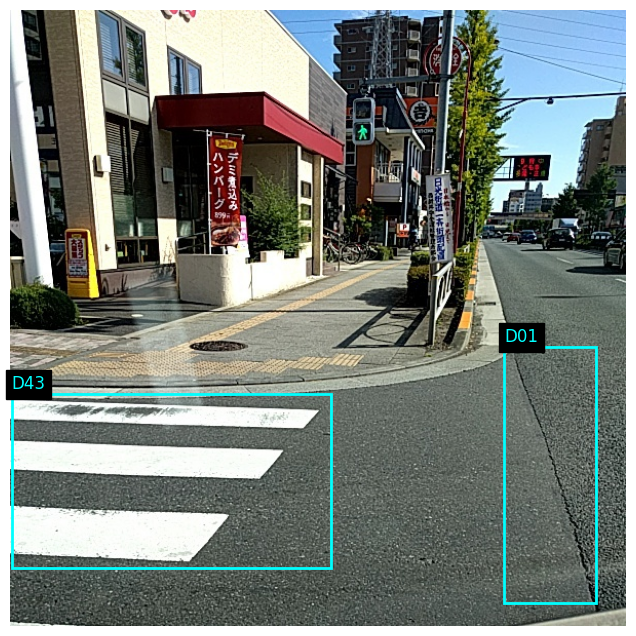

In [3]:
import os
import random
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image


# Пути к данным
dataset_path = "/Users/olya/Desktop/Diploma/RoadDamageDataset/Adachi/SplitDataset/test"  # Замени на свою папку с тестовыми данными
image_dir = os.path.join(dataset_path, "images")
annotation_dir = os.path.join(dataset_path, "annotations")

# Получаем список всех изображений
image_files = sorted([f for f in os.listdir(image_dir) if f.endswith(".jpg")])

# Функция для чтения аннотаций из XML-файлов
def parse_annotation(annotation_path):
    tree = ET.parse(annotation_path)
    root = tree.getroot()
    
    boxes = []
    labels = []
    
    for obj in root.findall('object'):
        label = obj.find('name').text
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)
        
        boxes.append((xmin, ymin, xmax, ymax))
        labels.append(label)
    
    return boxes, labels

# Функция для визуализации bounding boxes на изображении
def draw_boxes(image_path, annotation_path):
    # Загружаем изображение
    image = Image.open(image_path)
    
    # Загружаем bounding boxes
    boxes, labels = parse_annotation(annotation_path)
    
    # Визуализируем изображение
    fig, ax = plt.subplots(1, figsize=(8, 8))
    ax.imshow(image)

    # Определяем цвета для разных классов дефектов
    colors = {"D00": "red", "D10": "blue", "D20": "green", "D40": "yellow"}  # Примеры классов
    default_color = "cyan"
    
    # Рисуем bounding boxes
    for i, (xmin, ymin, xmax, ymax) in enumerate(boxes):
        label = labels[i]
        color = colors.get(label, default_color)
        
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(rect)
        ax.text(xmin, ymin - 5, label, color=color, fontsize=12, backgroundcolor="black")

    plt.axis("off")
    plt.show()

# Выбираем случайное изображение из тестовой выборки
random_image = random.choice(image_files)
random_annotation = random_image.replace(".jpg", ".xml")

# Пути к файлам
image_path = os.path.join(image_dir, random_image)
annotation_path = os.path.join(annotation_dir, random_annotation)

# Отображаем изображение с bounding boxes
draw_boxes(image_path, annotation_path)